In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
import kss
import re
from konlpy.tag import Mecab

class Prep():
        
    def Clean_text(self, text): # noisy한 문장을 cleaning
        self.sentences = []
        
        for i in range(len(text)):
            if (i+1) % 10 == 0:
                print(str(i+1) + 'th sentence is spliting...')
        
            temp = re.sub("[^가-힣a-z0-9.?]", ' ', text[i]) #한글, 영어, 숫자, 온점, 물음표가 아닌 것을 공백으로 삭제
            temp = re.sub("[.]{2,}", ".", temp) # 반복되는 온점 (...) 삭제
            temp = re.sub("[?]{2,}", "?", temp) # 반복되는 물음표 (?) 삭제
            temp = re.sub("[!]{2,}", "!", temp) # 반복되는 느낌표 (!) 삭제
            temp = re.sub("[' ']{2,}", " ", temp) # 반복되는 공백 삭제 
            temp = kss.split_sentences(temp)  #문장 분리

            for tmp in temp:
                self.sentences.append(tmp)
        
        return self.sentences

        
    def Tokenizer(self, sentences): # cleaned data에 대한 형태소 분석 후 vocabulary 구축
        
        self.corpus = []
        self.words = []
        self.vocab = []
        
        tokenizer = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
        
        for sent in self.sentences:
            temp = tokenizer.morphs(sent)
            self.corpus.append(temp)
            
            for tmp in temp:
                self.words.append(tmp)

        self.vocab = set(self.words)
        
        return self.corpus, self.words, self.vocab
    
    def Make_dict(self,vocab): # 만들어진 Vocabulary를 기준으로 단어-정수 및 정수-단어 인덱싱 dictionary 생성
        self.word_dict = {w: i for i, w in enumerate(vocab)}
        self.index_dict = {i: w for i, w in enumerate(vocab)}
        return self.word_dict, self.index_dict 
    
    def Get_clean(self, text): #위의 세가지 메소드를 한번에 진행                
        sentences =  self.Clean_text(text)
        corpus, words, vocab = self.Tokenizer(sentences)
        word_dict, index_dict = self.Make_dict(vocab)
        
        return sentences, corpus, words, vocab, word_dict, index_dict

In [3]:
class Make_pairs(): # Input과 target, label을 만들어주는 클래스
    
    def __init__(self):
        
        from collections import defaultdict
        self.inputs = [] 
        self.targets = []
        self.labels = []
        self.vocab_size = len(vocab)
        
        # Negative sampling 정의
        self.wordFreq = defaultdict(int)
        for word in words:
            self.wordFreq[word] += 1
        
        self.SumFreq = sum([freq**(3/4) for freq in self.wordFreq.values()]) # 분모
        self.wordProb = {word:((freq**(3/4))/self.SumFreq) for word, freq in self.wordFreq.items()} #샘플링 확률분포
        
    def Draw(self,n_sample): # n_sample : sample을 몇 개를 뽑을건지?
        negsam = []
        for i in range(n_sample):
            negsam.append(np.random.choice(list(self.wordProb.keys()), p=list(self.wordProb.values()))) #확률분포 P에 따른 추출
        
        return negsam
    
    def Get_pairs(self, window_size, n_negsam):
        for c in corpus: # for each sentence          
            for idx in range(len(c)): # for each idx
                start = max(0,idx - window_size)
                tail = min(idx + window_size, len(c)-1)
            
                #add negative samples to context
                context = c[start:idx] + c[idx+1:tail+1]
                needed_negsam = 2*window_size+n_negsam - len(context) # needed number of negative samples
                negsam = self.Draw(needed_negsam) # draw negative samples
            
                #stack pairs        
                
                in_onehot = torch.zeros(self.vocab_size) #make input one-hot
                in_onehot[word_dict[c[idx]]] = 1.0
                
                out = context+negsam
                out_onehot = torch.zeros(len(out), self.vocab_size) #make output one-hot

                for idx, txt in enumerate(out):
                    out_onehot[idx,word_dict[txt]] = 1.0
                
                self.inputs.append(in_onehot)
                self.targets.append(out_onehot)
                self.labels.append([1]*len(context) + [0]*needed_negsam)
                   
        return self.inputs, self.targets, self.labels   

In [5]:
from torch.autograd import Variable
import torch.optim as optim
def train(inputs, targets, labels, emb_dim, lr, n_epoch):
    
    vocab_size = len(vocab)
    target_size = len(targets[0])
    center_mat = Variable(torch.nn.init.xavier_normal_(torch.empty(emb_dim, vocab_size)).cuda(),requires_grad=True) # W mat
    context_mat = Variable(torch.nn.init.xavier_normal_(torch.empty(vocab_size, emb_dim)).cuda(),requires_grad=True) # W' mat
    
    for epoch in range(n_epoch): 
        loss_value = 0
        for batch in range(len(inputs)):
            
            x = Variable(inputs[batch].cuda()) # word index of input
            target = Variable(targets[batch].cuda()) # word index of target
            h = torch.matmul(center_mat,x) # look-up table
            
            tar = torch.matmul(target,context_mat)
            z = torch.matmul(tar,h)             
            y = torch.LongTensor(labels[batch]).cuda()

            y_hat = F.log_softmax(z, dim=0)
            loss = F.nll_loss(y_hat, y)
            loss_value += loss.item()
            loss.backward()
            
            center_mat.data -= lr * center_mat.grad.data # update center_mat
            context_mat.data -= lr * context_mat.grad.data # update context_mat with context_tmp
            
            # initialize gradient after update
            center_mat.grad.data.zero_() 
            context_mat.grad.data.zero_()
        
        if epoch % 100 == 0:
            print(f"Loss at this epoch {epoch+100}: {loss_value / vocab_size}")
        
    return center_mat         

In [6]:
def TSNEplot(wordvec, vocab, perplexity):
    
    #matplotlib 패키지 한글 깨짐 처리
    import matplotlib.pyplot as plt
    %matplotlib notebook
    plt.rc('font', family='Malgun Gothic') #윈도우, 구글 콜랩
    plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

    from sklearn.manifold import TSNE
    
    wordvec_2d = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', init='random').fit_transform(wordvec)
    plt.scatter(wordvec_2d[:,0], wordvec_2d[:,1], s=0.5)

    test_words=[]
    for i in range(len(vocab)):
        test_words.append(index_dict[i])
    
    for i, word in enumerate(test_words):
        plt.annotate(word, xy=(wordvec_2d[i, 0], wordvec_2d[i, 1]))
    
    return wordvec_2d    

[Korean Sentence Splitter]: Initializing Pynori...


Loss at this epoch 100: 4.146936824447231
Loss at this epoch 200: 0.9877724024883815
Loss at this epoch 300: 0.8893085772410574
Loss at this epoch 400: 0.8739204509827112
Loss at this epoch 500: 0.8682573619252684


<IPython.core.display.Javascript object>


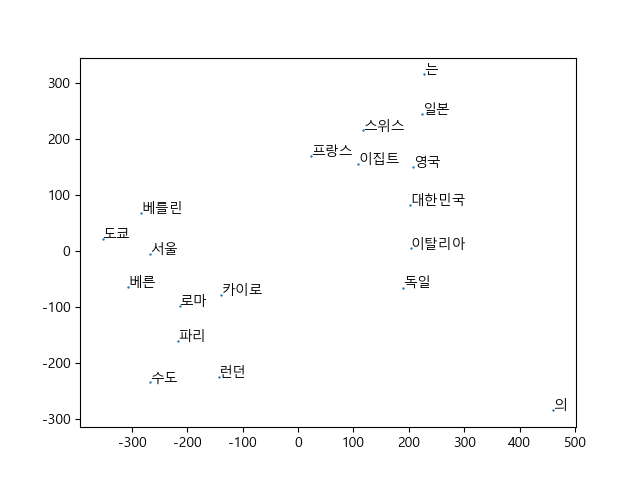

In [7]:
# Library import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


# 간단한 Corpus
text = ['대한민국의 수도는 서울',
       '독일의 수도는 베를린',
       '프랑스의 수도는 파리',
       '스위스의 수도는 베른',
       '일본의 수도는 도쿄',
       '이탈리아의 수도는 로마',
       '영국의 수도는 런던',
       '이집트의 수도는 카이로'
       ]        

#parameters
emb_dim = 20
window_size = 2
n_negsam = 3
lr = 0.01
n_epoch = 500

sentences, corpus, words, vocab, word_dict, index_dict = Prep().Get_clean(text) # 전처리
inputs, targets, labels = Make_pairs().Get_pairs(window_size, n_negsam) # Input / target / label 생성
center_mat = train(inputs, targets, labels, emb_dim, lr, n_epoch) # Training

embedded = center_mat.to('cpu').detach().numpy()
wordvec_2d = TSNEplot(embedded.T, vocab, perplexity=4) # TNSE plotting